# Housing Prices Competiting for Kaggle Learn Users

https://www.kaggle.com/c/home-data-for-ml-course

In [2]:
import warnings

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv('./train.csv', index_col='Id')
df_test = pd.read_csv('./test.csv', index_col='Id')
df = pd.concat([df_train, df_test], axis=0)

# load data description file
with open('./data_description.txt', 'r') as f:
    data_descr = f.read()

# print(data_descr)

In [5]:
df_train.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
3          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4          Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
5          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

   MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                             
1        0      2    2008        WD         Normal     208500  
2        0      5    2007        WD         Normal     181500  
3        0      9    2008        WD         Normal     223500  
4        0      2    2006        WD        Abnorml     140000  
5        0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

# Data cleaning

### Munging

In [7]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt and YearRemodAdd are corrupt, 
    # so we'll replace them with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    df['YearRemodAdd'] = df['YearRemodAdd'].where(df.YearRemodAdd < df.YearBuilt, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True)
    return df

---

### Encoding

In [8]:
# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The nominative (unordered) categorical features
features_nom = [
    "MSSubClass", "MSZoning", "Street", "Alley", 
    "LandContour", "LotConfig", "Neighborhood", 
    "Condition1", "Condition2", "BldgType", "HouseStyle", 
    "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", 
    "MasVnrType", "Foundation", "Heating", "CentralAir", 
    "GarageType", "MiscFeature", "SaleType", "SaleCondition"
]


# The ordinal (ordered) categorical features 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}

def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df

---

### Imputing

In [9]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

# ---------------------------------------


numerical_cols = [cname for cname in df.select_dtypes(['number'])]
categorical_cols = [cname for cname in df.select_dtypes(['category'])]
# numerical features preprocessing
numerical_transformer = SimpleImputer(strategy='median')
# categorical features preprocessing
categorical_transformer = SimpleImputer(strategy='most_frequent')
# complete transformer
imputer = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Limpieza

In [10]:
df = clean(df)
df = encode(df)

In [11]:
# first imputing method

df = impute(df.copy())
# X_train_first_approach = df_first_approach.loc[df_train.index, :]
# y_train_first_approach = X_train_first_approach.pop('SalePrice')


# --------------------------------


# second imputing method

# for now commented 
# df_scnd_approach = pd.DataFrame(
#     imputer.fit_transform(df), 
#     columns=df.columns
# )
# X_train_second_approach = df_scnd_approach.loc[df_train.index, :]

# y_train_second_approach = X_train_second_approach.pop('SalePrice')

Los dos enfoques de imputación toman decisiones distintas con respecto a las variables numéricas y a las categóricas
1. Numéricas: el primer enfoque imputa valores faltantes con ceros, mientras que el segundo los imputa con la mediana.
2. Categóricas: el primer enfoque imputa valores faltantes con valor None, mientras que el segundo los imputa con el valor más frecuente de la variable.

Para evaluar las distintas decisiones del proceso de wrangling (y, en adelante, también del feature engineering) dejaré una función con un modelo baseline

In [14]:
def score_dataset(X, y, model=XGBRegressor(random_state=0)):    
    # Label encoding for categoricals
    #
    # Using label encoding since 
    # defaul model is XGBRegressor
    X = X.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [15]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(
        data=mi_scores,
        index=X.columns
    ).sort_values(ascending=False)
    return mi_scores

In [16]:
X_train = df.loc[df_train.index, :]
y_train = X_train.pop('SalePrice')

X_test = df.loc[df_test.index, :].drop('SalePrice', axis=1)

In [17]:
score_dataset(X_train, y_train)

0.13994650533037123

# Exploración

In [19]:
most_correlated_features = X_train.corrwith(y_train).sort_values(ascending=False)

In [20]:
most_correlated_features[:10]

GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
FirstFlrSF      0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.522897
GarageYrBlt     0.508043
dtype: float64

In [21]:
mi_scores = make_mi_scores(X_train, y_train)

In [22]:
mi_scores[:10]

OverallQual     0.548479
Neighborhood    0.491537
GrLivArea       0.481120
GarageCars      0.373762
YearRemodAdd    0.372675
TotalBsmtSF     0.371533
YearBuilt       0.366292
GarageArea      0.360082
BsmtQual        0.331892
KitchenQual     0.319737
dtype: float64

In [31]:
mi_scores.sort_values()[:10]

Utilities     0.000000
LandSlope     0.000000
PoolQC        0.000000
PoolArea      0.000000
RoofStyle     0.000000
Street        0.000000
RoofMatl      0.000000
Condition2    0.000000
MoSold        0.000000
Functional    0.001884
dtype: float64

Para evitar que el modelo sobre-ajuste, saco las variables que no reducen en nada la incertidumbre con respecto al target.

In [27]:
X_train = X_train.loc[:, mi_scores>0.0]

In [28]:
score_dataset(X_train, y_train)

0.13996030423895528

## Feature engineering

In [32]:
def mathematical_transforms(df):
    X = pd.DataFrame()  # dataframe to hold new features
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    # This feature ended up not helping performance
    # X["TotalOutsideSF"] = \
    #     df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + \
    #     df.Threeseasonporch + df.ScreenPorch
    return X


def interactions(df):
    X = pd.get_dummies(df.BldgType, prefix="Bldg")
    X = X.mul(df.GrLivArea, axis=0)
    return X


def counts(df):
    X = pd.DataFrame()
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X


# def break_down(df):
#     X = pd.DataFrame()
#     X["MSClass"] = df.MSSubClass.str.split("_", n=1, expand=True)[0]
#     return X


def group_transforms(df):
    X = pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    return X

In [33]:
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

---

# Feature extraction

### PCA

Con cuatro features numéricas que altamente relacioandas con el target

Tener en cuenta: Groups of highly correlated features often yield interesting loadings


In [34]:
features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]
pc_columns = [f'PC_{n+1}' for n in range(len(features))]
X_scaled = StandardScaler().fit_transform(X_train[features])
pca = PCA()
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [35]:
# loadings
pd.DataFrame(
    pca.components_.T,
    columns=pc_columns,
    index=features
)

PC_1      PC_2      PC_3      PC_4
GarageArea    0.551058 -0.072323 -0.466623  0.688017
YearRemodAdd  0.449172 -0.736723 -0.088993 -0.497558
TotalBsmtSF   0.524652  0.115494  0.829210  0.154310
GrLivArea     0.468316  0.662321 -0.294539 -0.505230

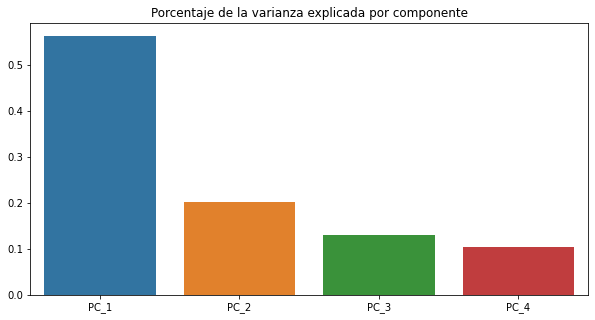

In [36]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(
    x=pc_columns,
    y=pca.explained_variance_ratio_)
plt.title('Porcentaje de la varianza explicada por componente')
plt.show()

Una primera alternativa para feature extraction con PCA es agregar los componentes como features, para lo cual creo la siguiente función

In [37]:
def generate_pca_components(X):
    X_scaled = StandardScaler().fit_transform(X)
    pc_columns = [f'PC_{n+1}' for n in range(len(X.columns))]
    return pd.DataFrame(
        data=pca.transform(X_scaled),
        columns=pc_columns
    )

In [38]:
X_pca = generate_pca_components(X_train[features])
X_pca.head()

PC_1      PC_2      PC_3      PC_4
0  0.597957 -0.607444 -0.747252 -0.539415
1  0.055698 -0.376781  0.543306  0.195992
2  0.867220 -0.466267 -0.793954 -0.363889
3 -0.582243  1.490512 -0.886097  1.171454
4  2.076667  0.059703 -1.094366  0.069448

Una segunda alternativa es definir nuevos features a partir de lo que indican los loadings.

In [39]:
def pca_inspired(df):
    X = pd.DataFrame()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    X["Feature2"] = df.YearRemodAdd * df.TotalBsmtSF
    return X

In [40]:
# outlier detection
idx = X_pca['PC_1'].sort_values(ascending=False).index
df.iloc[idx][['SalePrice', 'Neighborhood', 'SaleCondition']+ features] 

SalePrice Neighborhood SaleCondition  GarageArea  YearRemodAdd  \
Id                                                                     
1299   160000.0      Edwards       Partial      1418.0          2008   
524    184750.0      Edwards       Partial       884.0          2007   
1183   745000.0      NoRidge       Abnorml       813.0          1996   
692    755000.0      NoRidge        Normal       832.0          1994   
497    430000.0      NoRidge        Normal       546.0          1992   
...         ...          ...           ...         ...           ...   
1138    94000.0       Sawyer        Normal         0.0          1875   
529     86000.0      Edwards        Normal         0.0          1920   
706     55000.0       IDOTRR        Normal         0.0          1930   
521    106250.0      OldTown        Normal         0.0          1900   
534     39300.0      BrkSide        Normal         0.0          1946   

      TotalBsmtSF  GrLivArea  
Id                            
1299       6110.0       5642  
524        3138.0       4676  
1183       2396.0       4476  
692        2444.0       4316  
497        3200.0       3228  
...           ...        ...  
1138        780.0       1020  
529         528.0        605  
706           0.0       1092  
521           0.0       1294  
534           0.0        334  

[1460 rows x 7 columns]

Se dice que una venta es *parcial* cuando una propiedad tiene más de unx propietarix y algunx decide vender su parte. Esto suele ocurrir en el contexto de una sucesión o la disolución de un negocio, por lo que estas propiedades no suelen estar publicadas en una plataforma inmobiliaria. Por lo tanto, este tipo de casos deberían ser filtrados de un modelo que busca predecir precios de propiedades publicadas.

El análisis de *outliers* muestra que hay dos casas en el barrio Edwards en venta parcial. El modelo podría favorecerse de indicar estos casos con una tabla de booleanos.

In [41]:
def indicate_outliers(df):
    X_new = pd.DataFrame()
    X_new["Outlier"] = (df.Neighborhood == "Edwards") & (df.SaleCondition == "Partial")
    return X_new

---

### Clustering

In [42]:
def create_kmeans(n_clusters):
    return Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=n_clusters, n_init=50, random_state=0))
    ])

def cluster_distances(X, n_clusters):
    cluster_pipe = create_kmeans(n_clusters)
    distances = pd.DataFrame(
        data=cluster_pipe.fit_transform(X)
    )
    return distances

def cluster_labels(X, n_clusters):
    cluster_pipe = create_kmeans(n_clusters)
    labels = pd.Series(
        data=cluster_pipe.fit_predict(X)
    )
    return labels

def eval_n_clusters(n: int, method: str = 'labels', features=X_train.columns):
    methods = {
        'distances': cluster_distances(n_clusters),
        'labels': cluster_labels(n_clusters)
    }
    train_data = X_train.join(
        pd.DataFrame(methods[method])
    )
    return score_dataset(train_data, y_train)

In [43]:
cluster_features = [
    'LotArea',
    'TotalBsmtSF',
    'FirstFlrSF',
    'SecondFlrSF',
    'GrLivArea'
]

# eval_n_clusters(10, features=cluster_features)

---

# Aplicando todas las transformaciones

In [48]:
X_test = X_test.loc[:, mi_scores>0.0]
X = pd.concat([X_train, X_test], axis=0)

# created features
feature_transforms = [
    mathematical_transforms,
    interactions,
    counts,
#     break_down,
    group_transforms
]
for transform in feature_transforms:
    X = X.join(transform(X))
    
    
# PCA
X = X.join(pca_inspired(X))
# X = X.join(pca_components(X, pca_features))
# X = X.join(indicate_outliers(X))


# Clustering
# X = X.join(cluster_labels(X, cluster_features, n_clusters=20))
# X = X.join(cluster_distance(X, cluster_features, n_clusters=20))

X = label_encode(X)

X_train = X.loc[df_train.index, :]
X_test = X.loc[df_test.index, :]

---

## Modeling

In [49]:
param_grid = {
    'max_depth': np.arange(2,11, 2),
    'n_estimators': np.arange(1000,8001,1000),
    'learning_rate': [.001, .05, .1],
    'min_child_weight': np.arange(1,11, 2),
    'colsample_bytree': np.append(np.arange(.2,1,.3),1),
    'subsample': np.append(np.arange(.2,1,.3),1),
    'reg_alpha': np.arange(0,11,2),
    'reg_lambda': np.arange(0,11,2)
}

model = XGBRegressor(random_state=0)
search = GridSearchCV(model, param_grid, n_jobs=-1)
# search.fit(X_train, y_train)

In [58]:
xgb_params = dict(
    max_depth=6,           
    learning_rate=0.01,    
    n_estimators=8000,     
    min_child_weight=1,    
    colsample_bytree=0.7,  
    subsample=0.7,         
    reg_alpha=0.5,         
    reg_lambda=1.0,        
    num_parallel_tree=1,   
)

xgb = XGBRegressor(**xgb_params)
score_dataset(X_train, y_train, xgb)
# xgb.fit(X_train, np.log(y_train))

0.1223247220732127

In [59]:
xgb = XGBRegressor(**xgb_params)
xgb.fit(X_train, np.log(y_train))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=8000, n_jobs=8, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0.5,
             reg_lambda=1.0, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [60]:
predictions = np.exp(xgb.predict(X_test))

In [61]:
predictions

array([121960.734, 161292.75 , 193945.05 , ..., 152627.23 , 118681.57 ,
       197489.27 ], dtype=float32)

In [ ]:
# XGB minimizes MSE, but competition loss is RMSLE
# So, we need to log-transform y to train and exp-transform the predictions
# xgb.fit(X_train, np.log(y))
# predictions = np.exp(xgb.predict(X_test))
# output = pd.DataFrame({
#     'id': df_test.index,
#     'SalePrice': predictions
# })
# output.to_csv('submission.csv', index=False)

In [63]:
output = pd.DataFrame({
    'id': df_test.index,
    'SalePrice': predictions
})
output.to_csv('submission.csv', index=False)

In [57]:
X_test

MSSubClass  MSZoning  LotFrontage  LotArea  Alley  LotShape  \
Id                                                                  
1461           0         2         80.0    11622      2         1   
1462           0         3         81.0    14267      2         2   
1463           5         3         74.0    13830      2         2   
1464           5         3         78.0     9978      2         2   
1465          11         3         43.0     5005      2         2   
...          ...       ...          ...      ...    ...       ...   
2915          13         4         21.0     1936      2         1   
2916          13         4         21.0     1894      2         1   
2917           0         3        160.0    20000      2         1   
2918           9         3         62.0    10441      2         1   
2919           5         3         74.0     9627      2         1   

      LandContour  LotConfig  Neighborhood  Condition1  ...  Bldg_1Fam  \
Id                                                      ...              
1461            3          4            12           1  ...        896   
1462            3          0            12           2  ...       1329   
1463            3          4             8           2  ...       1629   
1464            3          4             8           2  ...       1604   
1465            1          4            22           2  ...          0   
...           ...        ...           ...         ...  ...        ...   
2915            3          4            10           2  ...          0   
2916            3          4            10           2  ...          0   
2917            3          4            11           2  ...       1224   
2918            3          4            11           2  ...        970   
2919            3          4            11           2  ...       2000   

      Bldg_2fmCon  Bldg_Duplex  Bldg_Twnhs  Bldg_TwnhsE  Bldg_None  \
Id                                                                   
1461            0            0           0            0          0   
1462            0            0           0            0          0   
1463            0            0           0            0          0   
1464            0            0           0            0          0   
1465            0            0           0         1280          0   
...           ...          ...         ...          ...        ...   
2915            0            0        1092            0          0   
2916            0            0           0         1092          0   
2917            0            0           0            0          0   
2918            0            0           0            0          0   
2919            0            0           0            0          0   

      PorchTypes  MedNhbdArea  Feature1   Feature2  
Id                                                  
1461           2       1200.0    1778.0  1729602.0  
1462           2       1200.0    2658.0  2602182.0  
1463           2       1560.0    2557.0  1853216.0  
1464           2       1560.0    2530.0  1850148.0  
1465           2       1767.0    2560.0  2549760.0  
...          ...          ...       ...        ...  
2915           0       1092.0    1638.0  1075620.0  
2916           1       1092.0    1638.0  1075620.0  
2917           1       1282.0    2448.0  2399040.0  
2918           2       1282.0    1882.0  1816704.0  
2919           2       1282.0    2996.0  1985028.0  

[1459 rows x 82 columns]

In [56]:
output

id      SalePrice
0     1461  123692.921875
1     1462  163580.140625
2     1463  192989.500000
3     1464  194523.171875
4     1465  190709.093750
...    ...            ...
1454  2915   86882.640625
1455  2916   86958.570312
1456  2917  148981.468750
1457  2918  119888.890625
1458  2919  200748.921875

[1459 rows x 2 columns]